In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/dataset/klasifikasi_jump_squat/model3

/content/drive/MyDrive/dataset/klasifikasi_jump_squat/model3


In [ ]:
ls

landmark_jump_squat_test_data.csv  landmark_jump_squat_train_data.csv


In [ ]:
!pip install -q opencv-python

In [ ]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

# Define function to run pose estimation using MoveNet Thunder.
# You'll apply MoveNet's cropping algorithm and run inference multiple times on
# the input image to improve pose estimation accuracy.
def detect(input_tensor, inference_count=3):
  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(),
                            reset_crop_region=False)

  return person

Cloning into 'examples'...
remote: Enumerating objects: 23745, done.
remote: Total 23745 (delta 0), reused 0 (delta 0), pack-reused 23745
Receiving objects: 100% (23745/23745), 44.08 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (12942/12942), done.
Updating files: 100% (2850/2850), done.


#Load CSVs preprocessed ke TRAIN dan TEST dataset.

In [ ]:
csvs_out_test_path = 'landmark_jump_squat_test_data.csv'
csvs_out_train_path = 'landmark_jump_squat_train_data.csv'


def load_pose_landmarks(csv_path):
  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')


  return X, y, classes, dataframe

In [ ]:
# csvs_out_test_path = 'landmark_jump_squat_test_data.csv'
# csvs_out_train_path = 'landmark_jump_squat_train_data.csv'


# def load_pose_landmarks(csv_path):
#   # Load the CSV file
#   dataframe = pd.read_csv(csv_path)
#   df_to_process = dataframe.copy()

#   # Drop the file_name columns as you don't need it during training.
#   df_to_process.drop(columns=['file_name'], inplace=True)

#   # Extract the list of class names
#   classes = df_to_process.pop('class_name').unique()

#   # Extract the labels
#   y = df_to_process.pop('class_no')

#   # Convert the input features and labels into the correct format for training.
#   X = df_to_process.astype('float64')
#   y = keras.utils.to_categorical(y)

#   return X, y, classes, dataframe

In [ ]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [ ]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

###Define functions to convert the pose landmarks to a pose embedding (a.k.a. feature vector) for pose classification

In [ ]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center,
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

# Define the model

In [ ]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(1, activation="sigmoid")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 17, 3)                0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 17, 2)                0         ['reshape[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpL  (None, 2)                    0         ['tf.__operators__.getitem

In [ ]:
# # Define the model
# inputs = tf.keras.Input(shape=(51))
# embedding = landmarks_to_embedding(inputs)

# layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
# layer = keras.layers.Dropout(0.5)(layer)
# layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
# layer = keras.layers.Dropout(0.5)(layer)
# outputs = keras.layers.Dense(len(class_names), activation="sigmoid")(layer)

# model = keras.Model(inputs, outputs)
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 51)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 17, 3)                0         ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.getitem (  (None, 17, 2)                0         ['reshape[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.compat.v1.gather (TFOpL  (None, 2)                    0         ['tf.__operators__.getitem

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=10)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
17/19 [=========================>....] - ETA: 0s - loss: 0.6557 - accuracy: 0.7518 
Epoch 1: val_accuracy improved from -inf to 0.85294, saving model to weights.best.hdf5
19/19 [==============================] - 2s 28ms/step - loss: 0.6515 - accuracy: 0.7578 - val_loss: 0.5739 - val_accuracy: 0.8529
Epoch 2/200
16/19 [========================>.....] - ETA: 0s - loss: 0.5516 - accuracy: 0.8096
Epoch 2: val_accuracy did not improve from 0.85294
19/19 [==============================] - 0s 6ms/step - loss: 0.5446 - accuracy: 0.8106 - val_loss: 0.4369 - val_accuracy: 0.8529
Epoch 3/200
 1/19 [>.............................] - ETA: 0s - loss: 0.4397 - accuracy: 0.8594

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_accuracy did not improve from 0.85294
19/19 [==============================] - 0s 5ms/step - loss: 0.4747 - accuracy: 0.8106 - val_loss: 0.3872 - val_accuracy: 0.8529
Epoch 4/200
18/19 [===========================>..] - ETA: 0s - loss: 0.4522 - accuracy: 0.8108
Epoch 4: val_accuracy did not improve from 0.85294
19/19 [==============================] - 0s 5ms/step - loss: 0.4525 - accuracy: 0.8106 - val_loss: 0.3663 - val_accuracy: 0.8529
Epoch 5/200
 1/19 [>.............................] - ETA: 0s - loss: 0.4286 - accuracy: 0.8125
Epoch 5: val_accuracy did not improve from 0.85294
19/19 [==============================] - 0s 6ms/step - loss: 0.4232 - accuracy: 0.8114 - val_loss: 0.3369 - val_accuracy: 0.8529
Epoch 6/200
13/19 [===================>..........] - ETA: 0s - loss: 0.3975 - accuracy: 0.8185
Epoch 6: val_accuracy improved from 0.85294 to 0.86275, saving model to weights.best.hdf5
19/19 [==============================] - 0s 10ms/step - loss: 0.3948 - accuracy: 0.8

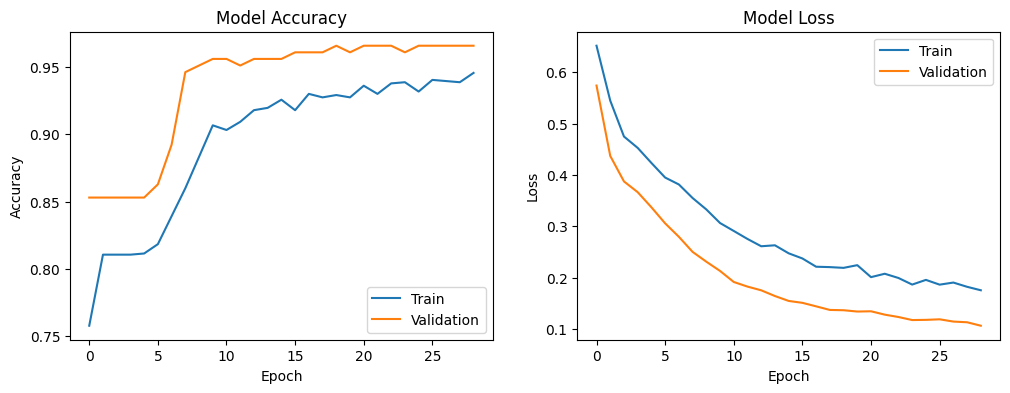

In [ ]:
# Plot the learning curves
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.show()

# Plot the learning curves
plot_learning_curve(history)

In [ ]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

11/11 [==============================] - 0s 2ms/step - loss: 0.0792 - accuracy: 0.9673


11/11 [==============================] - 0s 3ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

        down       1.00      0.89      0.94        62
    standing       0.98      1.00      0.99       274

    accuracy                           0.98       336
   macro avg       0.99      0.94      0.96       336
weighted avg       0.98      0.98      0.98       336



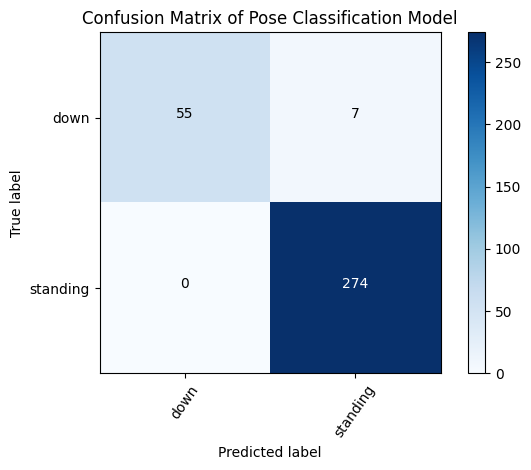

In [ ]:
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#   """Plots the confusion matrix."""
#   if normalize:
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print("Normalized confusion matrix")
#   else:
#     print('Confusion matrix, without normalization')

#   plt.imshow(cm, interpolation='nearest', cmap=cmap)
#   plt.title(title)
#   plt.colorbar()
#   tick_marks = np.arange(len(classes))
#   plt.xticks(tick_marks, classes, rotation=55)
#   plt.yticks(tick_marks, classes)
#   fmt = '.2f' if normalize else 'd'
#   thresh = cm.max() / 2.
#   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], fmt),
#               horizontalalignment="center",
#               color="white" if cm[i, j] > thresh else "black")

#   plt.ylabel('True label')
#   plt.xlabel('Predicted label')
#   plt.tight_layout()

# # Classify pose in the TEST dataset using the trained model
# y_pred = model.predict(X_test)

# # Convert the prediction result to class name
# y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
# y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# # Plot the confusion matrix
# cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
# plot_confusion_matrix(cm,
#                       class_names,
#                       title ='Confusion Matrix of Pose Classification Model')

# # Print the classification report
# print('\nClassification Report:\n', classification_report(y_true_label,
#                                                           y_pred_label))

#Convert the pose classification model to TensorFlow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('jump_squat.tflite', 'wb') as f:
  f.write(tflite_model)

Model size: 25KB


In [ ]:
with open('jump_squat_labels.txt', 'w') as f:
  f.write('\n'.join(class_names))

In [ ]:
def evaluate_model(interpreter, X, y_true):
  """Evaluates the given TFLite model and return its accuracy."""
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on all given poses.
  y_pred = []
  for i in range(len(y_true)):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = X[i: i + 1].astype('float32')
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the class with highest
    # probability.
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    y_pred.append(predicted_label)

  # Compare prediction results with ground truth labels to calculate accuracy.
  y_pred = keras.utils.to_categorical(y_pred)
  return accuracy_score(y_true, y_pred)

# Evaluate the accuracy of the converted TFLite model
classifier_interpreter = tf.lite.Interpreter(model_content=tflite_model)
classifier_interpreter.allocate_tensors()
print('Accuracy of TFLite model: %s' %
      evaluate_model(classifier_interpreter, X_test, y_test))

Accuracy of TFLite model: 0.8154761904761905


###Install TensorFlow Lite Metadata Writer

In [ ]:
!pip install tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 17.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
from tflite_support.metadata_writers import writer_utils
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import metadata_info

In [ ]:
# Define paths for the TFLite model and the metadata output
model_path = 'jump_squat.tflite'
model_with_metadata_path = 'jump_squat_with_metadata.tflite'
label_file = 'jump_squat_labels.txt'

# Create the ImageClassifierWriter
writer = image_classifier.MetadataWriter.create_for_inference(
    writer_utils.load_file(model_path),
    input_norm_mean=[127.5],
    input_norm_std=[127.5],
    label_file_paths=[label_file]
)

# Populate the metadata buffer
metadata_buf = writer.populate()

# Save the metadata to the model
# First save the original model bytes
with open(model_with_metadata_path, 'wb') as f:
    f.write(writer_utils.load_file(model_path))

# Then attach the metadata to the model
# Using writer_utils to update the model file
model_with_metadata = writer_utils.load_file(model_with_metadata_path)
with open(model_with_metadata_path, 'wb') as f:
    f.write(model_with_metadata + metadata_buf)

print("Metadata added to the model")

Metadata added to the model
